In [18]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *


# Get Data 
---

In [19]:
# merge_ohlc_closing_prices('binance_data/top_100_tickers/2024/1m')

 * ## Closing Price Data


In [20]:

#prices = pd.read_csv("binance_data/Staked_ETH_Bybit/merged_closing_prices.csv", index_col=0, parse_dates=True)

#prices = pd.read_csv("binance_data/From_Paper/2023/1m/merged_From_Paper_closing_prices_OCT_NOV.csv", index_col=0, parse_dates=True)

#BTC and WBTC
#-------------------------------------------
#prices = pd.read_csv("binance_data/Wrapped BTC/2024/30m/merged_closing_prices.csv", index_col=0, parse_dates=True)

#prices = pd.read_csv("binance_data/Wrapped BTC/2024/1m/merged_closing_prices.csv", index_col=0, parse_dates=True)


#SOL and BNSOL
#-------------------------------------------
#prices = pd.read_csv('binance_data/SOL_and_BNSOL/2025/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#ETH and WBTC
#-------------------------------------------
#prices = pd.read_csv('binance_data/ETH_and_WBETH/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#Top 100
#-------------------------------------------
prices = pd.read_csv('binance_data/top_100_tickers/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

In [21]:
prices = prices[['XRP/USDT_2024_1m', 'ADA/USDT_2024_1m']]

#prices = prices[['DOT/USDT_2024_1m', 'XTZ/USDT_2024_1m']]

#BCH/USDT_2024_1m & DOGE/USDT_2024_1m
#-------------------------------------------
#prices = prices[['BCH/USDT_2024_1m', 'DOGE/USDT_2024_1m']]

#GALA/USDT_2024_1m & GRT/USDT_2024_1m,0.0056584346126191745,-4.071777010162084
#-------------------------------------------
#prices = prices[['GALA/USDT_2024_1m', 'GRT/USDT_2024_1m']]

In [22]:
prices

,XRP/USDT_2024_1m,ADA/USDT_2024_1m
timestamp,,
2024-01-01 00:00:00,0.6155,0.5940
2024-01-01 00:01:00,0.6159,0.5947
2024-01-01 00:02:00,0.6163,0.5948
2024-01-01 00:03:00,0.6165,0.5960
2024-01-01 00:04:00,0.6168,0.5971
...,...,...
2024-06-30 23:55:00,0.4763,0.3926
2024-06-30 23:56:00,0.4762,0.3924
2024-06-30 23:57:00,0.4763,0.3924


In [23]:
# count_unchanged_rows = (prices.diff().eq(0).all(axis=1)).sum()
# print("Number of fully unchanged rows:", count_unchanged_rows)

In [24]:
# prices = prices[prices.diff().ne(0).all(axis=1)]

In [25]:
# count_unchanged_rows = (prices.diff().eq(0).all(axis=1)).sum()
# print("Number of fully unchanged rows:", count_unchanged_rows)

 * ## Order book data


In [26]:
# #BTC and WBTC
# #-------------------------------------------
#prices = pd.read_csv('order_book_data/merged_data/1min/btc_wbtc_combined_1m.csv', index_col=0, parse_dates=True)

#ETH and WBETH
#prices = pd.read_csv('order_book_data/merged_data/1min/eth_wbeth_combined_1m.csv', index_col=0, parse_dates=True)


In [27]:
# Only show mid prices
#prices = prices[['btc_mid_price', 'wbtc_mid_price']]

#prices = prices[['eth_mid_price','wbeth_mid_price']]

In [28]:
# #Fliter prices to end in May
# prices = prices.loc['2024-01-01':'2024-05-31']

In [29]:
# prices_ETH = pd.read_csv('binance_data/ETH_and_WBETH/2024/1m/ETHUSDT_2024_1m.csv', index_col=0, parse_dates=True)
# prices_WBETH = pd.read_csv('binance_data/ETH_and_WBETH/2024/1m/WBETHUSDT_2024_1m.csv', index_col=0, parse_dates=True)   
# prices_WBTC = pd.read_csv('binance_data/Wrapped BTC/2024/1m/WBTCUSDT_2024_1m.csv', index_col=0, parse_dates=True)
# prices_BTC = pd.read_csv('binance_data/Wrapped BTC/2024/1m/BTCUSDT_2024_1m.csv', index_col=0, parse_dates=True)

In [30]:
#get prices for dates greater than or equal to 2024-01-01 16:30:00	

#prices = prices.loc[prices.index >= "2024-01-01 16:30:00"]

# Trading simulation
---

* ## In-Sample Testing

In [31]:
# #XVS/USDT_2024_30m & QI/USDT_2024_30m


# crypto_1 = prices.columns[0]
# crypto_2 = prices.columns[1]

# cointegrated_pairs = [(crypto_1,
#   crypto_2,
#   0.731393,
#   0.8501886494196308,
#   0.22)]

In [32]:
#Params:
window_size = 1440
entry_threshold= 3 #3 was prev
exit_threshold= 0
stop_loss_threshold = 100

In [33]:
prices.columns

Index(['XRP/USDT_2024_1m', 'ADA/USDT_2024_1m'], dtype='object')

## For Closing Price Data 
---

In [34]:
sym1, sym2 = prices.columns
print(f"\nTesting strategy on pair: {sym1} and {sym2} ...")
S1 = prices[sym1]
S2 = prices[sym2]

# Compute the spread series and beta_series 
spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

#                                   FOR CLOSING PRICE DATA
#------------------------------------------------------------------------------------------
# Generate trading signals (positions) based on the spread's z-score
positions, trade_entries, trade_exits = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)



Testing strategy on pair: XRP/USDT_2024_1m and ADA/USDT_2024_1m ...
Total trades closed: 151 (Wins=151, Losses=0)
Win rate: 1.00


## For Order Book Data 
---

In [35]:
prices.columns

Index(['XRP/USDT_2024_1m', 'ADA/USDT_2024_1m'], dtype='object')

In [36]:
# sym1, S1_ask_price, S1_bid_price,S1_ask_amount,S1_bid_amount,sym2,S2_ask_price, S2_bid_price,S2_ask_amount,S2_bid_amount  = prices.columns
# print(f"\nTesting strategy on pair: {sym1} and {sym2} ...")

# #Gather relevant columns from order book data
# #-------------------------------------------
# S1_mid_price = prices[sym1]
# S2_mid_price = prices[sym2]
# #-------------------------------------------
# S1_ask_price = prices[S1_ask_price]
# S1_ask_amount = prices[S1_ask_amount]
# S1_bid_price = prices[S1_bid_price]
# S1_bid_amount = prices[S1_bid_amount]
# #-------------------------------------------
# S2_ask_price = prices[S2_ask_price]
# S2_ask_amount = prices[S2_ask_amount]
# S2_bid_price = prices[S2_bid_price]
# S2_bid_amount = prices[S2_bid_amount]
# #-------------------------------------------

# # Compute the spread series and beta_series 
# spread_series, beta_series, alpha_series = compute_spread_series(S1_mid_price, S2_mid_price, window_size)
# #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# # Compute rolling z-score using the provided helper function.
# zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

# #                                   FOR CLOSING PRICE DATA
# #------------------------------------------------------------------------------------------
# # Generate trading signals (positions) based on the spread's z-score
# #positions, trade_entries, trade_exits = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)

# #                                   FOR ORDER BOOK DATA
# #------------------------------------------------------------------------------------------
# positions, trade_entries, trade_exits = backtest_pair_rolling_order_book(spread_series,
#                                                                          S1_mid_price,
#                                                                          S2_mid_price,
#                                                                          S1_ask_price,
#                                                                          S1_ask_amount,
#                                                                          S1_bid_price,
#                                                                          S1_bid_amount,
#                                                                          S2_ask_price,
#                                                                          S2_ask_amount,
#                                                                          S2_bid_price,
#                                                                          S2_bid_amount,
#                                                                          zscore_series, 
#                                                                          entry_threshold, 
#                                                                          exit_threshold, 
#                                                                          stop_loss_threshold)



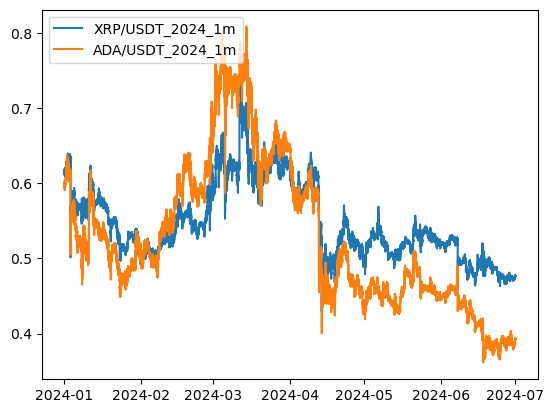

In [37]:
#Plot the closing prices of the merged data using different y axis

crypto_1 = prices.columns[0]
crypto_2 = prices.columns[1]

plt.plot(prices[crypto_1], label=crypto_1)
plt.plot(prices[crypto_2], label=crypto_2)
plt.legend(loc='upper left')
plt.show()






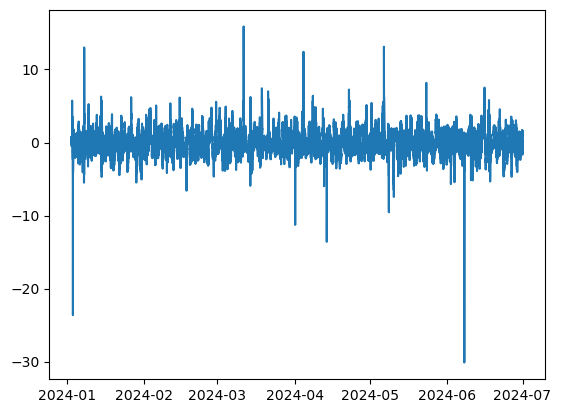

In [38]:
plt.plot(zscore_series)

In [39]:
initial_capital = 10_000.0
#tx_cost= 0.00031 #0.031% transaction cost
tx_cost= 0.00025 #0.025% transaction cost #Binance level 5 Maker Cost

trade_profits, cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series, tx_cost)

Total trades: 151
Number of profitable trades (proft > 0): 102
Number of non-profitable trades (proft < 0): 49
Total return €: -83.23
Total return %: -0.83%
Long spread losses: 23, Short spread losses: 26
Number of Dual-leg profitable trades: 34
Dual leg trade profit rate: 22.52%


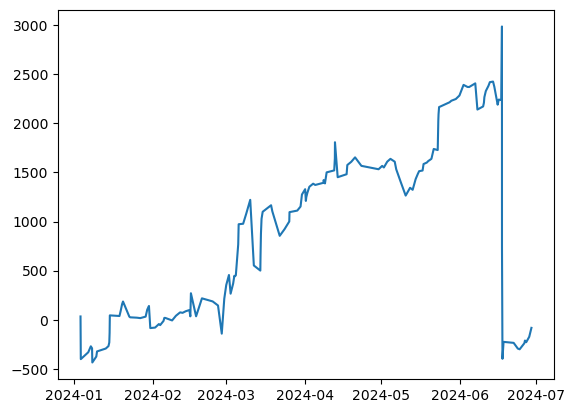

In [40]:
plt.plot(cumulative_profit_series)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         1.,  2.,  2.,  2.,  1.,  4.,  0.,  4.,  8., 20., 25., 33., 17.,
        12.,  4.,  4.,  1.,  2.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-2.24404591e+03, -2.21411152e+03, -2.18417713e+03, -2.15424274e+03,
        -2.12430835e+03, -2.09437395e+03, -2.06443956e+03, -2.03450517e+03,
        -2.00457078e+03, -1.97463639e+03, -1.94470200e+03, -1.91476760e+03,
        -1.88483321e+03, -1.85489882e+03, -1.82496443e+03, -1.79503004e+03,
        -1.76509565e+03, -1.73516126e+03, -1.70522686e+03, -1.67529247e+03,
        -1.64535808e+03, -1.61542369e+03, -1.58548930e

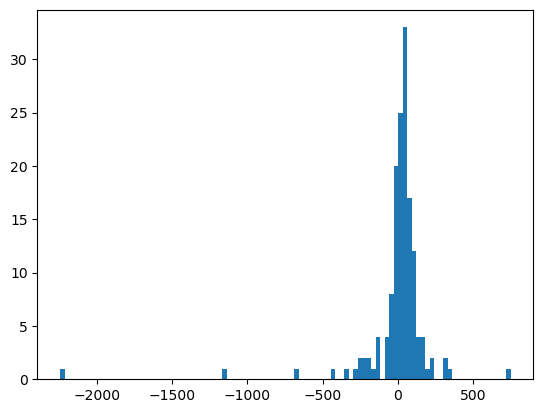

In [41]:
plt.hist(trade_profits, bins=100)

In [42]:
#Filter for negative values

trade_profits_neg = [x for x in trade_profits if x < 0]
print(f"Average trade loss:  € {np.mean(trade_profits_neg)}")

trade_profits_pos = [x for x in trade_profits if x > 0]
print(f"Average trade win:  € {np.mean(trade_profits_pos)}")

print("Number of negative profits(profits that were less than the transaction cost): ", len(trade_profits_neg))
print("Number of positive profits (profits that were greater than the transaction cost): ", len(trade_profits_pos))



Average trade loss:  € -163.23865188248956
Average trade win:  € 77.60254313493374
Number of negative profits(profits that were less than the transaction cost):  49
Number of positive profits (profits that were greater than the transaction cost):  102


In [43]:
#Get index of greatest loss
max_loss_index = trade_profits.index(min(trade_profits))
max_loss_index

140

In [44]:
trade_entries[max_loss_index]

{'time': Timestamp('2024-06-17 16:19:00'),
 'S1': 0.4993,
 'S2': 0.3911,
 'z': -3.948339931906931,
 'position': 1}

In [45]:
trade_exits[max_loss_index]

{'time': Timestamp('2024-06-17 16:32:00'),
 'S1': 0.5052,
 'S2': 0.4021,
 'z': 0.02127954590733836,
 'exit_type': 'win'}

In [46]:
print(f"MAX LOSS: {trade_profits[max_loss_index]}")

MAX LOSS: -2244.0459126451233


In [47]:
#Get trade entry and exit times
trade_entry_min_profit = entry_times[max_loss_index],
trade_exit_min_profit = exit_times[max_loss_index]

print(f"Trade entry time: {trade_entry_min_profit}")
print(f"Trade exit time: {trade_exit_min_profit}")

Trade entry time: (Timestamp('2024-06-17 16:19:00'),)
Trade exit time: 2024-06-17 16:32:00


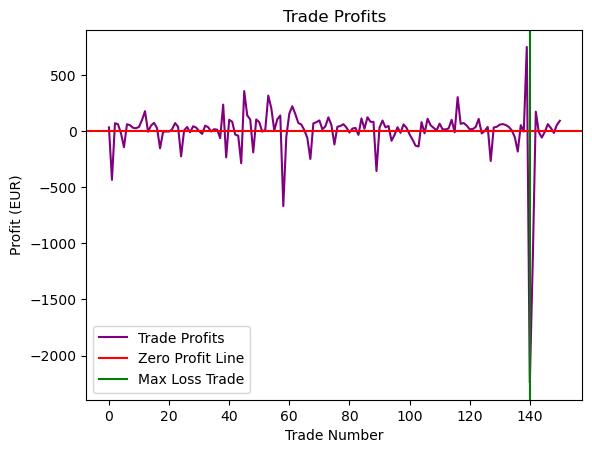

In [48]:
plt.plot(trade_profits, label='Trade Profits', color = 'purple')
plt.axhline(y=0, color='r', linestyle='-', label='Zero Profit Line')
plt.axvline(x=max_loss_index, color='g', linestyle='-', label='Max Loss Trade')
plt.title('Trade Profits')
plt.xlabel('Trade Number')
plt.ylabel('Profit (EUR)')
plt.legend()

Average trade duration: 330.75 minutes


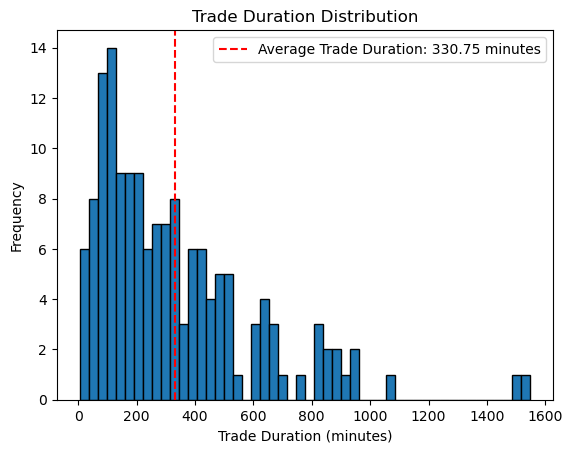

In [49]:
#Calculate the durations of all the trades
#trade_durations = [exit - entry for entry, exit in zip(entry_times, exit_times)]
trade_durations = [(exit_time - entry_time).total_seconds() / 60 for entry_time, exit_time in zip(entry_times, exit_times)]

average_trade_duration = np.mean(trade_durations)
print(f"Average trade duration: {average_trade_duration:.2f} minutes")
#Plot distribution of trade durations
plt.hist(trade_durations, bins=50, edgecolor='black')
plt.axvline(x=average_trade_duration, color='red', linestyle='--', label=f'Average Trade Duration: {average_trade_duration:.2f} minutes')
plt.xlabel('Trade Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Trade Duration Distribution')
plt.legend()
plt.show()

In [50]:
trade_durations[1]

113.0

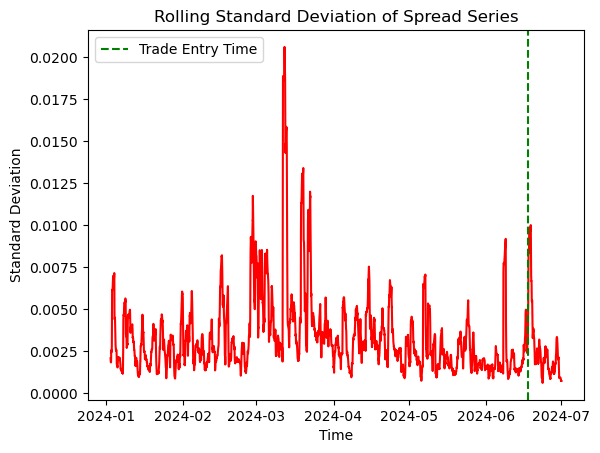

In [51]:
plt.plot(rolling_std, color = 'red')
plt.axvline(trade_entry_min_profit, color='green', linestyle='--', label='Trade Entry Time')
plt.xlabel('Time')
plt.ylabel('Standard Deviation')
plt.title('Rolling Standard Deviation of Spread Series')
plt.legend()


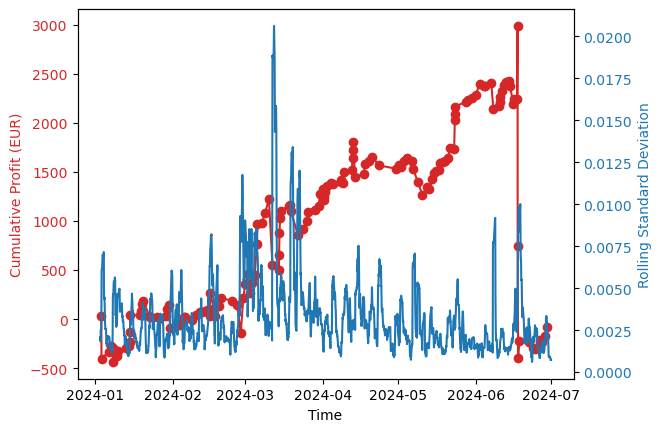

In [52]:
#Plot cumulative profit series and rolling standard deviation on same plot

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')      
ax1.set_ylabel('Cumulative Profit (EUR)', color=color)
ax1.plot(cumulative_profit_series, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Rolling Standard Deviation', color=color)
ax2.plot(rolling_std, color=color)
ax2.tick_params(axis='y', labelcolor=color) 


140

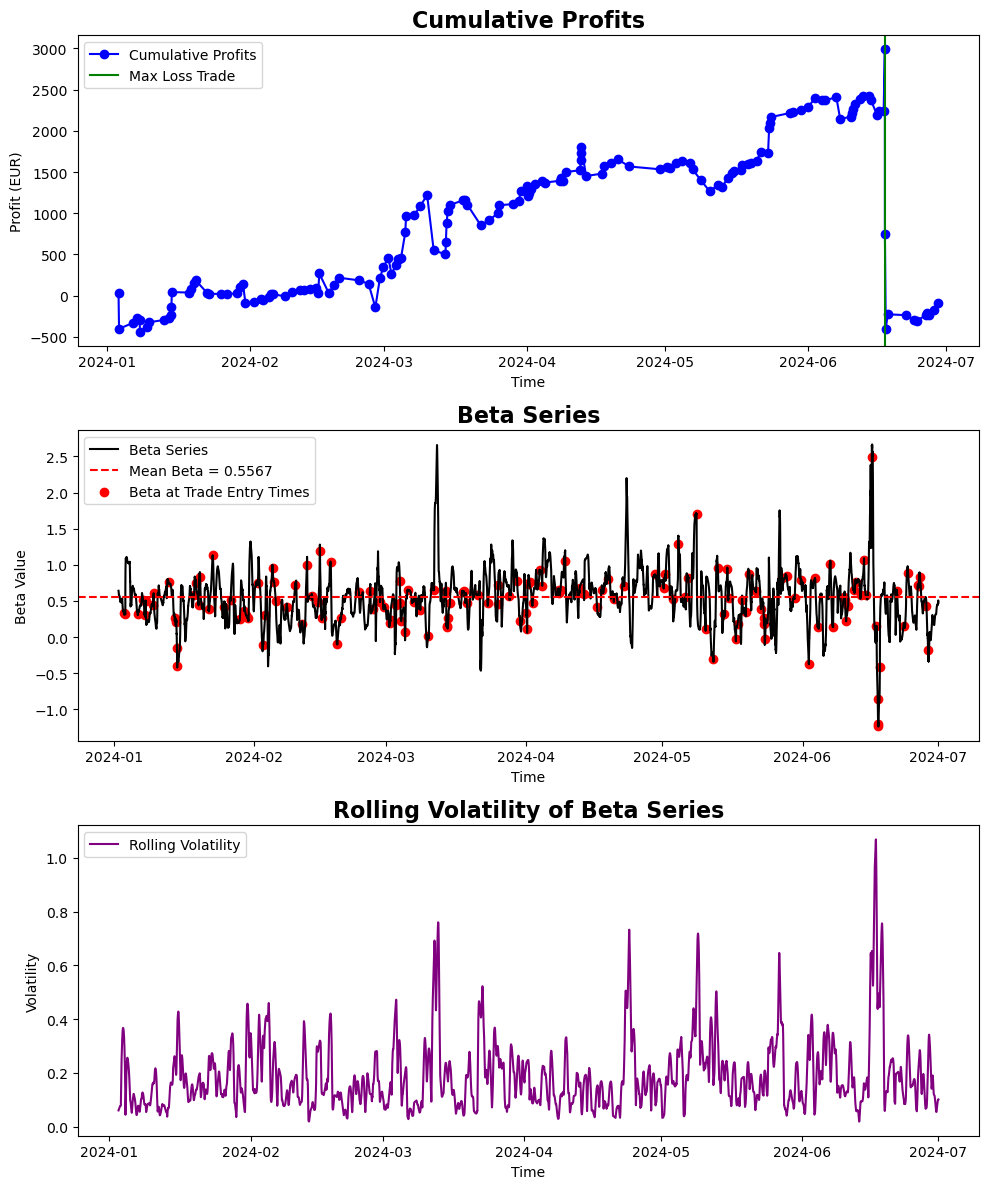

In [95]:
# Create a figure for stacked plots
plt.figure(figsize=(10, 12))

# First subplot: Cumulative Profits
plt.subplot(3, 1, 1)
plt.plot(cumulative_profit_series, label='Cumulative Profits', color='Blue', marker = 'o')
plt.axvline(x=trade_exit_min_profit, color='g', linestyle='-', label='Max Loss Trade')
plt.title('Cumulative Profits', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Profit (EUR)')
plt.legend()


# # First subplot: Trade Profits
# plt.subplot(4, 1, 2)
# plt.plot(trade_profits, label='Trade Profits', color='Green', marker='o')
# plt.title('Trade Profits', fontsize=16, fontweight='bold')
# plt.xlabel('Trade Number')
# plt.ylabel('Profit (EUR)')
# plt.legend()


# Second subplot: Beta Series with Mean Line
plt.subplot(3, 1, 2)
mean_beta = np.mean(beta_series)
plt.plot(beta_series, color='black', label='Beta Series')
plt.axhline(y=mean_beta, color='red', linestyle='--', label=f'Mean Beta = {mean_beta:.4f}')
plt.scatter(entry_times, [beta_series.loc[entry] for entry in entry_times], color='red', label='Beta at Trade Entry Times')
plt.title('Beta Series', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Beta Value')
plt.legend()

# Third subplot: Rolling Volatility of Beta Series
# Adjust the layout to 4 rows and 1 column
plt.subplot(3, 1, 3)
rolling_volatility = beta_series.rolling(window_size).std()
plt.plot(rolling_volatility, color='purple', label='Rolling Volatility')
plt.title('Rolling Volatility of Beta Series', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [99]:
#Zip Beta at entries profits per trade and trade duration together 
beta_at_entries_profits = list(zip(beta_series.loc[entry_times], trade_profits, trade_durations))



#Check if beta at entries is correlated with profits per trade

beta_at_entries_profits


[(0.3326158939606483, 32.85347954816128, 378.0),
 (0.3219468191743985, -434.765501758836, 113.0),
 (0.3235071411301577, 69.88471752455047, 325.0),
 (0.5118892881817235, 60.848586665178594, 161.0),
 (0.3019995936476253, -20.266698229383962, 125.0),
 (0.5024529289958619, -144.463012437916, 141.0),
 (0.44872544555481797, 60.392964540476385, 215.0),
 (0.6039668341982048, 52.23343945828008, 326.0),
 (0.7657234421685635, 29.32107232105219, 540.0),
 (0.27005020589614026, 24.96133898269008, 162.0),
 (0.2108781333456053, 37.259036437410636, 94.0),
 (-0.15496483669619768, 98.45096865592897, 50.0),
 (-0.4046917410318239, 177.1477571079103, 72.0),
 (0.5874266730373431, -6.302221287194945, 207.0),
 (0.7515299254769019, 48.82307618070133, 245.0),
 (0.44143035315576507, 72.77444977001558, 288.0),
 (0.8315897908354668, 25.976471256094612, 306.0),
 (0.38391918690530963, -153.7972416891967, 939.0),
 (1.1316267562678979, -7.294908950302197, 395.0),
 (0.41583173112519023, -3.7114381776185157, 655.0),
 (0.

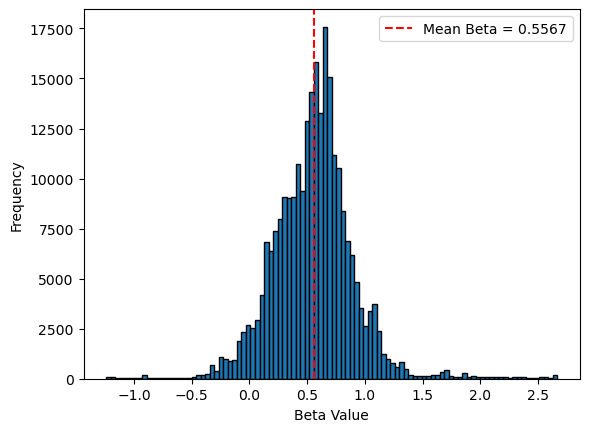

In [106]:
#Plot the distribution of beta series



plt.hist(beta_series, bins=100, edgecolor='black')
plt.axvline(x=np.mean(beta_series), color='red', linestyle='--', label=f'Mean Beta = {mean_beta:.4f}')
plt.xlabel('Beta Value')
plt.ylabel('Frequency')
plt.legend()

In [55]:
beta_series

timestamp
2024-01-01 00:00:00         NaN
2024-01-01 00:01:00         NaN
2024-01-01 00:02:00         NaN
2024-01-01 00:03:00         NaN
2024-01-01 00:04:00         NaN
                         ...   
2024-06-30 23:55:00    0.475751
2024-06-30 23:56:00    0.475358
2024-06-30 23:57:00    0.474984
2024-06-30 23:58:00    0.474679
2024-06-30 23:59:00    0.474260
Length: 262080, dtype: float64

# Relationship between returns volatility and Beta volatility
---

In [56]:
from scipy import stats


trade_ranges = [(entry, exit) for entry, exit in zip(entry_times, exit_times)]

#Get beta series in the trade ranges
beta_series_trade_ranges = [beta_series[entry:exit] for entry, exit in trade_ranges]

#Calcullate the volatility of the beta series in the trade ranges
volatility_trade_ranges = [np.std(beta_series_trade_range) for beta_series_trade_range in beta_series_trade_ranges]

#Calculate range of the beta series in the trade ranges
abs_beta_trade_ranges = [np.abs(np.max(beta_series_trade_range) - np.min(beta_series_trade_range)) for beta_series_trade_range in beta_series_trade_ranges]

#Calculate the absolute returns for each trade
absolute_trade_returns = [np.abs(trade_profit/initial_capital) for trade_profit in trade_profits]

#-------------------------------------------


# #Perform linear regression to determine if there is a relationship between absolute returns and volatility
# slope, intercept, r_value, p_value, std_err = stats.linregress(volatility_trade_ranges, absolute_trade_returns)
# print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_value**2:.4f}, P-value: {p_value:.4f}, Standard Error: {std_err:.4f}")

# if p_value < 0.05:
#     print("There is a significant relationship between absolute returns and volatility")
# else:
#     print("There is no significant relationship between absolute returns and volatility")

# #Plot the relationship between absolute returns and volatility with a linear regression line
# plt.scatter(volatility_trade_ranges, absolute_trade_returns)
# plt.plot(volatility_trade_ranges, [slope*volatility_val + intercept for volatility_val in volatility_trade_ranges], color='red', label='Linear Regression')
# plt.xlabel('Beta Volatility')
# plt.ylabel('Absolute Returns')
# plt.title('Absolute Returns vs Volatility')
# plt.legend()
# plt.show()

#-------------------------------------------



Text(0.5, 1.0, 'Absolute Returns vs Beta Range')

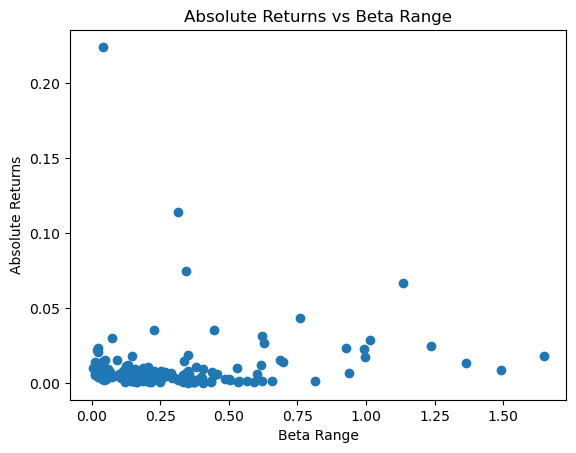

In [57]:
#Plot absolute_trade_returns vs abs_beta_trade_ranges
plt.scatter(abs_beta_trade_ranges, absolute_trade_returns)
plt.xlabel('Beta Range')
plt.ylabel('Absolute Returns')
plt.title('Absolute Returns vs Beta Range')

# Delta Neutrality 
---

Slope: 0.0156
Intercept: 0.0081
R-squared: 0.0119
P-value: 0.1821


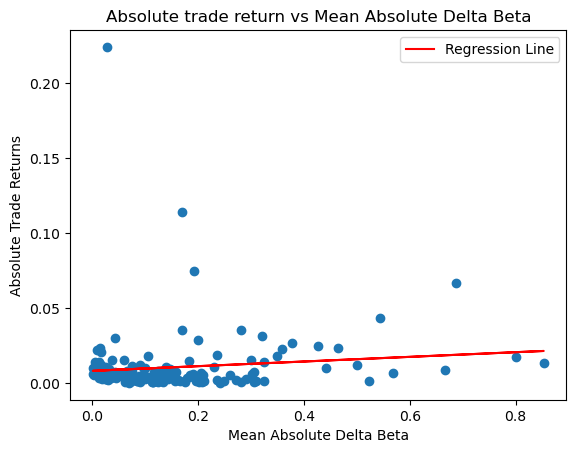

In [58]:
#Plot trade profits vs absolute delta neutrality

from scipy import stats

#Get actual Betas used for each trade entry
beta_entries = [beta_series[entry] for entry in entry_times]

trade_ranges = [(entry, exit) for entry, exit in zip(entry_times, exit_times)]

#Get beta series in the trade ranges

beta_series_trade_ranges = [beta_series[entry:exit].iloc[1:] for entry, exit in trade_ranges] #iloc[1:] to exclude the first beta value which is the same as the entry beta

#Calculate the absolute difference between the beta at the trade entry and the betas in the trade range
absolute_delta_betas = [np.abs(entry_beta - beta_range) for entry_beta, beta_range in zip(beta_entries, beta_series_trade_ranges)]

#Calculate the mean delta beta for each trade
mean_absolute_delta_betas = [np.mean(delta) for delta in absolute_delta_betas]


absolute_trade_returns = [np.abs(trade_profit/initial_capital) for trade_profit in trade_profits]

#Perform a regression analysis to determine if there is a relationship between delta neutrality and trade profits
slope, intercept, r_value, p_value, std_err = stats.linregress(mean_absolute_delta_betas, absolute_trade_returns)

print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

#Plot trade profits vs absolute delta neutrality and the regression line

plt.plot(mean_absolute_delta_betas, absolute_trade_returns, 'o',)
plt.plot(mean_absolute_delta_betas, intercept + slope*np.array(mean_absolute_delta_betas), 'r', label='Regression Line')
plt.xlabel('Mean Absolute Delta Beta')
plt.ylabel('Absolute Trade Returns')
plt.title('Absolute trade return vs Mean Absolute Delta Beta')
plt.legend()


Slope: 0.0086
Intercept: 0.0082
R-squared: 0.0123
P-value: 0.1746


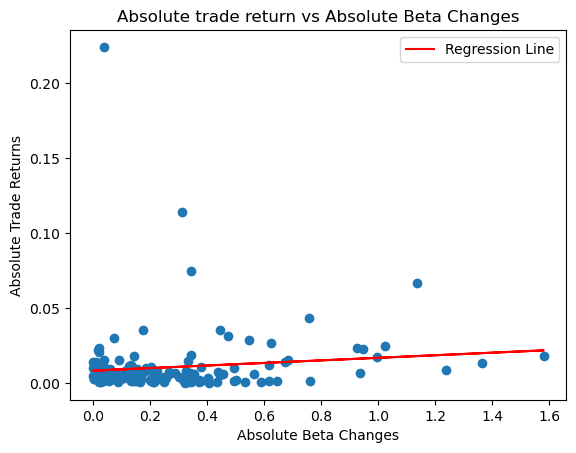

In [59]:
#Get entry beta for each trade
entry_betas = [beta_series[entry] for entry in entry_times]

#Get exit beta for each trade
exit_betas = [beta_series[exit] for exit in exit_times]

#Calculate the absolute difference between the entry and exit betas
absolute_beta_changes = [np.abs(exit - entry) for entry, exit in zip(entry_betas, exit_betas)]

#Regression analysis to determine if there is a relationship between beta changes and absolute trade returns

slope, intercept, r_value, p_value, std_err = stats.linregress(absolute_beta_changes, absolute_trade_returns)

print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

#Plot trade profits vs absolute beta changes and the regression line

plt.plot(absolute_beta_changes, absolute_trade_returns, 'o',)
plt.plot(absolute_beta_changes, intercept + slope*np.array(absolute_beta_changes), 'r', label='Regression Line')
plt.xlabel('Absolute Beta Changes')
plt.ylabel('Absolute Trade Returns')
plt.title('Absolute trade return vs Absolute Beta Changes')
plt.legend()

In [60]:
len(absolute_beta_changes)

151

In [61]:
#Get entry and exit betas for each trade
entry_betas = [beta_series[entry] for entry in entry_times]
exit_betas = [beta_series[exit] for exit in exit_times]

#Calculate the absolute difference between the entry and exit betas
absolute_beta_changes = [np.abs(exit - entry) for entry, exit in zip(entry_betas, exit_betas)]



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


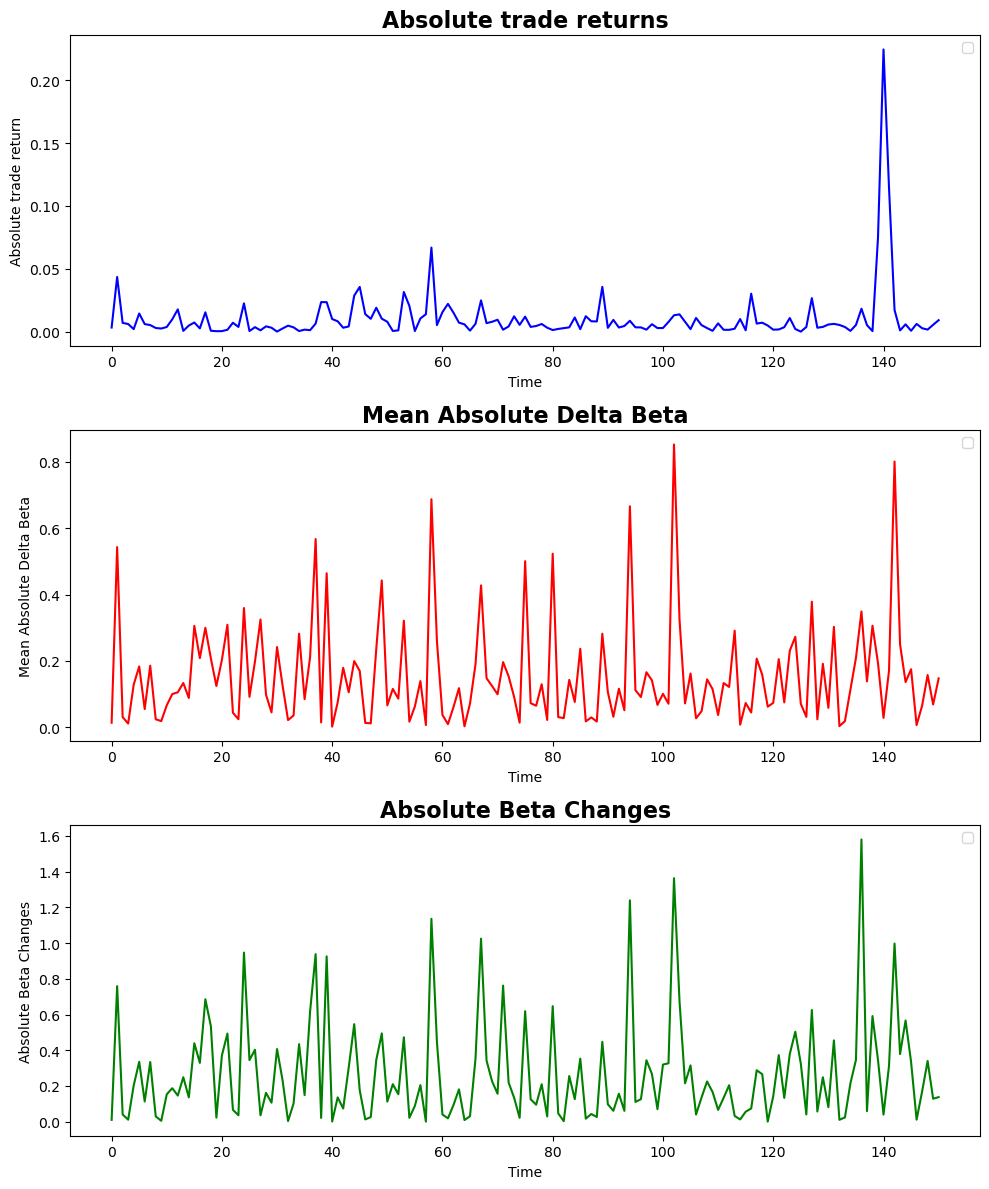

In [91]:
# Create a figure for stacked plots
plt.figure(figsize=(10, 12))

# First subplot: Cumulative Profits
plt.subplot(3, 1, 1)
plt.plot(absolute_trade_returns, color='Blue')
plt.title('Absolute trade returns', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Absolute trade return')
plt.legend()

#Second subplot: Mean Absolute Delta Beta
plt.subplot(3, 1, 2)
plt.plot(mean_absolute_delta_betas, color='red')
plt.title('Mean Absolute Delta Beta', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Mean Absolute Delta Beta')
plt.legend()

#Third subplot: Absolute Beta Changes
plt.subplot(3, 1, 3)
plt.plot(absolute_beta_changes, color='green')
plt.title('Absolute Beta Changes', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Absolute Beta Changes')
plt.legend()



# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Slope: 0.0002
Intercept: 0.1016
R-squared: 0.0856
P-value: 0.0003
There is a significant relationship between trade durations and mean absolute delta beta


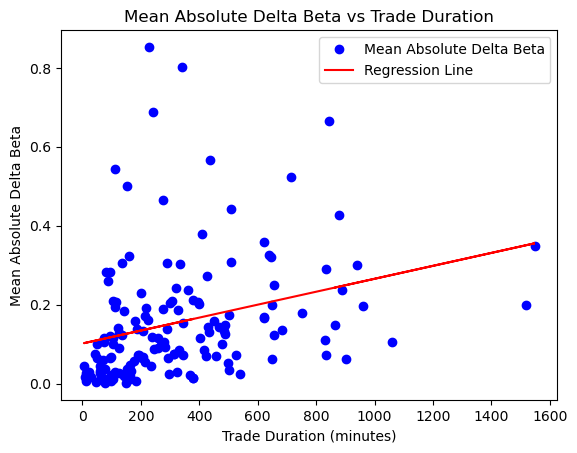

In [63]:
#Plot mean_absolute_delta_betas against trade durations with a regression line

#Perform a regression analysis to determine if there is a relationship between delta neutrality and trade profits
slope, intercept, r_value, p_value, std_err = stats.linregress(trade_durations, mean_absolute_delta_betas)

print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("There is a significant relationship between trade durations and mean absolute delta beta")
else:
    print("There is no significant relationship between trade durations and mean absolute delta beta")


#Plot trade profits vs absolute delta neutrality and the regression line
plt.plot(trade_durations, mean_absolute_delta_betas, 'o', label='Mean Absolute Delta Beta', color='blue')
plt.plot(trade_durations, intercept + slope*np.array(trade_durations), 'r', label='Regression Line')
plt.xlabel('Trade Duration (minutes)')
plt.ylabel('Mean Absolute Delta Beta')
plt.title('Mean Absolute Delta Beta vs Trade Duration')
plt.legend()
plt.show()


In [64]:
len(mean_absolute_delta_betas)

151

In [65]:
#Plot distributions of beta_series_trade_ranges in multiple subplots



In [66]:
len(beta_series_trade_ranges)

151

Text(0.5, 1.0, 'Rolling Standard Deviation of XRP/USDT_2024_1m')

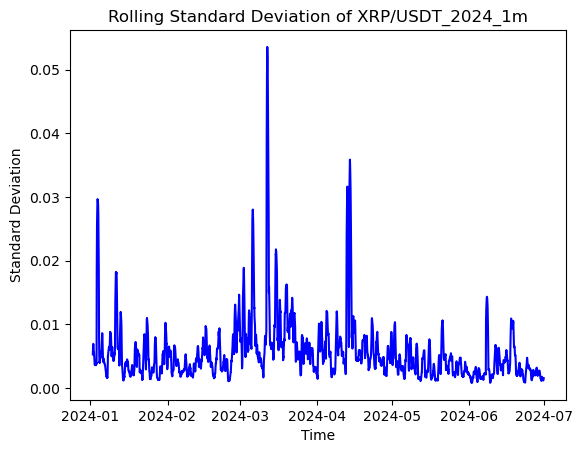

In [67]:
#Calculate rolling standard deviation of S1 and S2
rolling_std_S1 = S1.rolling(window=window_size).std()
rolling_std_S2 = S2.rolling(window=window_size).std()

#Plot the rolling standard deviation of S1 and S2 on separate plots

plt.plot(rolling_std_S1, color='blue')
plt.xlabel('Time')
plt.ylabel('Standard Deviation')
plt.title(f'Rolling Standard Deviation of {sym1}')




Text(0.5, 1.0, 'Rolling Standard Deviation of ADA/USDT_2024_1m')

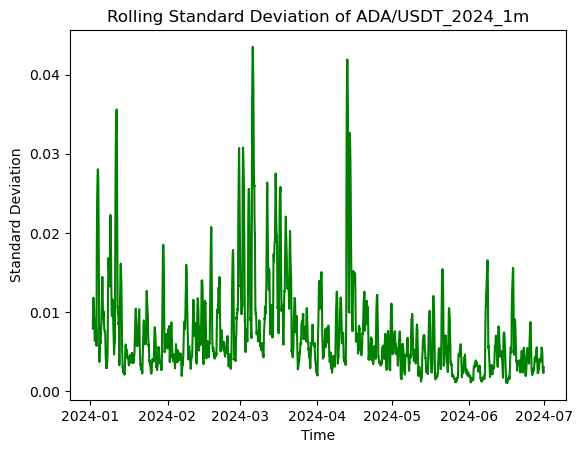

In [68]:
plt.plot(rolling_std_S2, color='green')
plt.xlabel('Time')
plt.ylabel('Standard Deviation')
plt.title(f'Rolling Standard Deviation of {sym2}')

In [69]:
#Get index of negative trade profits
negative_trade_profits_indeices = [i for i, x in enumerate(trade_profits) if x < 0]

#Get the corresponding trade entry and exit times
negative_trade_entry_times = [entry_times[i] for i in negative_trade_profits_indeices]
negative_trade_exit_times = [exit_times[i] for i in negative_trade_profits_indeices]


In [80]:
trade_exit_min_profit

Timestamp('2024-06-17 16:32:00')

Trade 1 : 2024-06-17 16:19:00 to 2024-06-17 16:32:00 (win)
Stop loss threshold is too high to be plotted


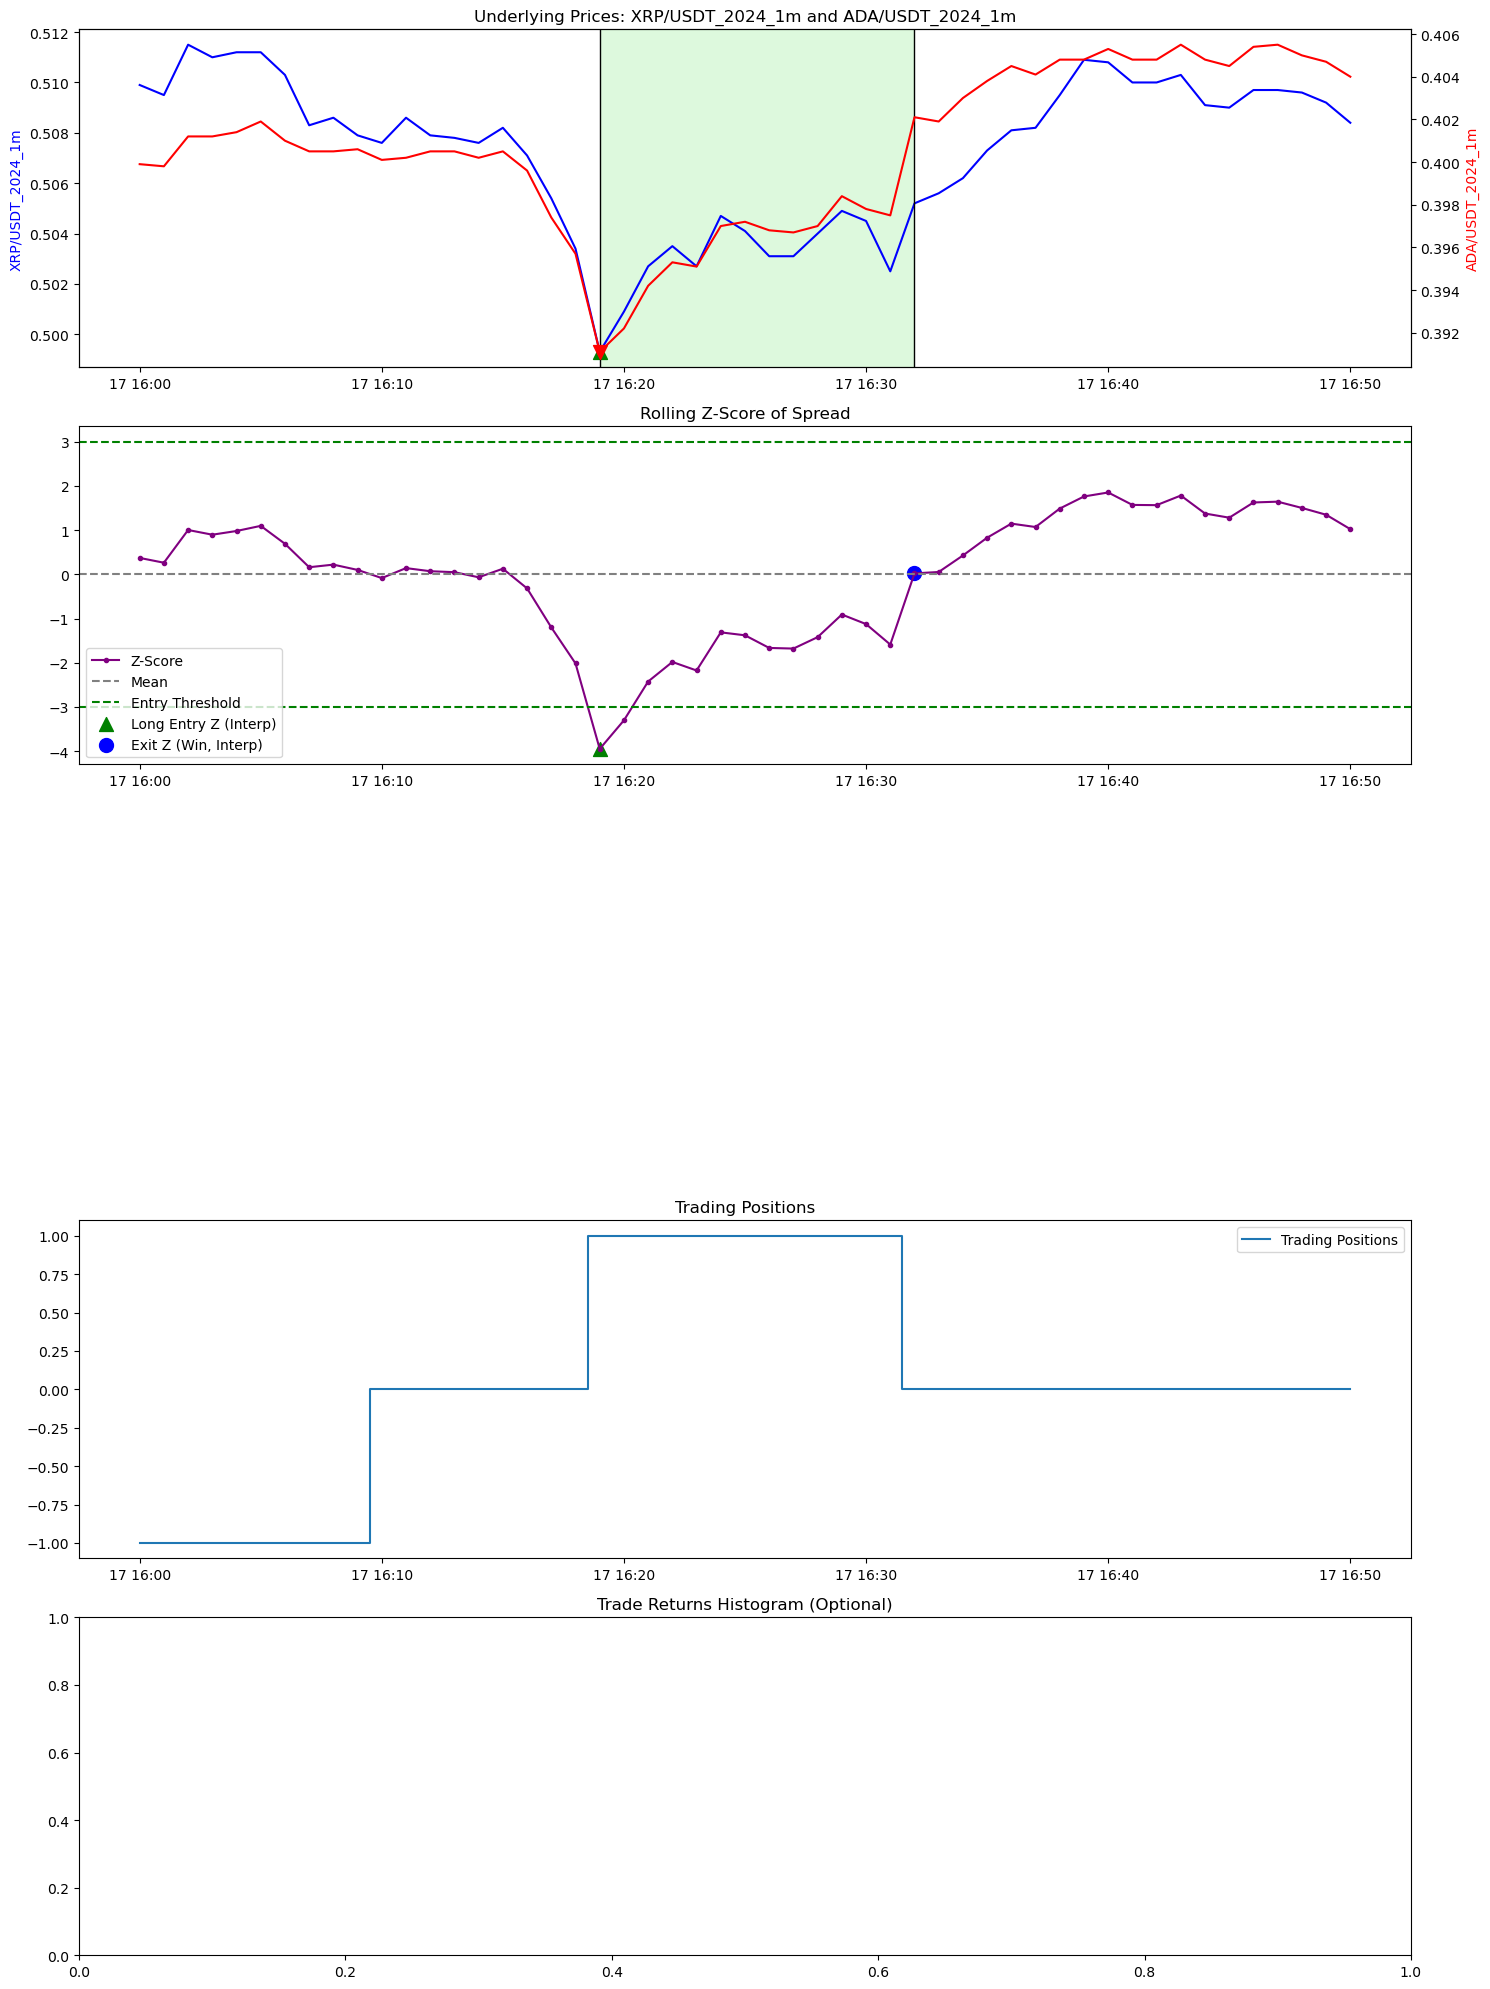

In [84]:
#Plot trading simulation

# window_start = pd.to_datetime('2024-03-01 00:00:00')
# window_end = pd.to_datetime('2024-03-25 00:00:00')

#Window for biggest loss
# window_start = pd.to_datetime(trade_entry_min_profit[0])
# window_end = pd.to_datetime(trade_exit_min_profit)

window_start = pd.to_datetime('2024-06-17 16:00:00')
window_end = pd.to_datetime('2024-06-17 16:50:00')


# window_start = None
# window_end = None

#NOTE THAT THE TIMES ON THE X AXIS SHOW THE HOURS AND MINUTES

# S1 = S1_mid_price
# S2 = S2_mid_price

plot_trading_simulation(
    S1, 
    S2, 
    sym1, 
    sym2, 
    zscore_series, 
    positions, 
    trade_profits,
    entry_threshold,
    stop_loss_threshold,
    trade_entries=trade_entries,  # list of dicts: { 'time', 'S1', 'S2', 'z', 'position' }
    trade_exits=trade_exits,    # list of dicts: { 'time', 'S1', 'S2', 'z', 'exit_type' }
    window_start=window_start,
    window_end=window_end
)



In [71]:
trade_exits

[{'time': Timestamp('2024-01-03 11:07:00'),
  'S1': 0.6308,
  'S2': 0.6126,
  'z': -0.020968560614498467,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-03 13:48:00'),
  'S1': 0.5657,
  'S2': 0.553,
  'z': 0.0519467949960364,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-06 12:21:00'),
  'S1': 0.5676,
  'S2': 0.5212,
  'z': 0.020078868312094263,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-07 12:41:00'),
  'S1': 0.5669,
  'S2': 0.5201,
  'z': 0.011194493092187528,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-08 00:21:00'),
  'S1': 0.5525,
  'S2': 0.4911,
  'z': 0.15898622683556127,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-08 02:52:00'),
  'S1': 0.5597,
  'S2': 0.4728,
  'z': -0.12715559070757634,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-09 16:31:00'),
  'S1': 0.5559,
  'S2': 0.5008,
  'z': 0.05051811974262393,
  'exit_type': 'win'},
 {'time': Timestamp('2024-01-09 23:34:00'),
  'S1': 0.566,
  'S2': 0.511,
  'z': -0.14013858103957472,
  'ex

In [72]:
#Check slippage

#Get timestampe of trade entries and exits
entry_times = [x['time'] for x in trade_entries]
exit_times = [x['time'] for x in trade_exits]

#Get the actual entry and exit prices of the two assets at the time of trade entries and exits
S1_actual_entry_prices = [x['S1'] for x in trade_entries]
S2_actual_entry_prices = [x['S2'] for x in trade_entries]

S1_actual_exit_prices = [x['S1'] for x in trade_exits]
S2_actual_exit_prices = [x['S2'] for x in trade_exits]

#Get the mid prices of the two assets at the time of trade entries and exits
S1_entry_mid_prices = S1_mid_price.loc[entry_times]
S2_entry_mid_prices = S2_mid_price.loc[entry_times]

S1_exit_mid_prices = S1_mid_price.loc[exit_times]
S2_exit_mid_prices = S2_mid_price.loc[exit_times]

#Get the slippage for the two assets
S1_entry_slippage_percentage = (S1_actual_entry_prices - S1_entry_mid_prices) / S1_entry_mid_prices * 100
S2_entry_slippage_percentage = (S2_actual_entry_prices - S2_entry_mid_prices) / S2_entry_mid_prices * 100

S1_exit_slippage_percentage = (S1_actual_exit_prices - S1_exit_mid_prices) / S1_exit_mid_prices * 100
S2_exit_slippage_percentage = (S2_actual_exit_prices - S2_exit_mid_prices) / S2_exit_mid_prices * 100


NameError: name 'S1_mid_price' is not defined

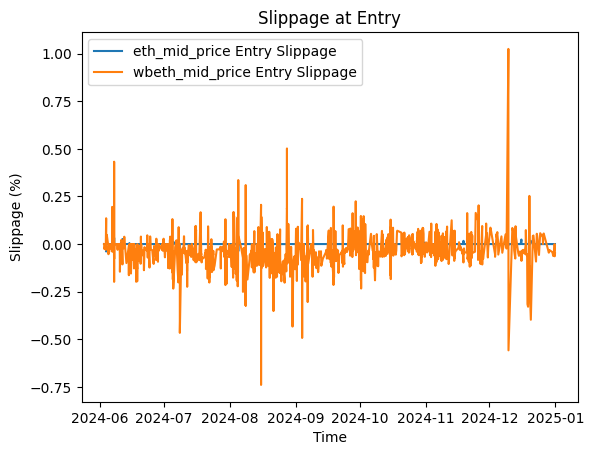

In [ ]:

#Create plots for slippage

plt.plot(S1_entry_slippage_percentage, label=f'{sym1} Entry Slippage')
plt.plot(S2_entry_slippage_percentage, label=f'{sym2} Entry Slippage')
plt.xlabel('Time')
plt.ylabel('Slippage (%)')
plt.title('Slippage at Entry')
plt.legend(loc='upper left')
plt.show()


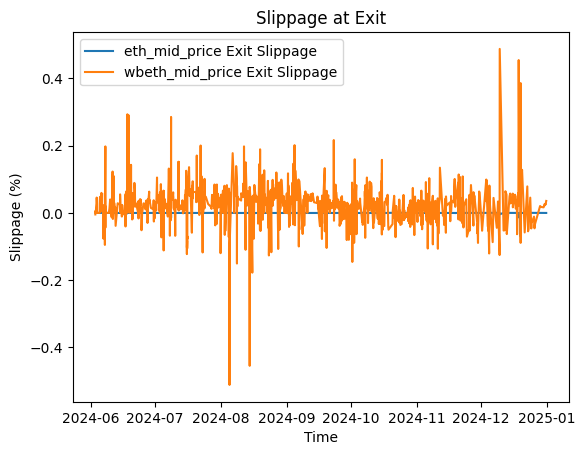

In [ ]:
plt.plot(S1_exit_slippage_percentage, label= f'{sym1} Exit Slippage')
plt.plot(S2_exit_slippage_percentage, label= f'{sym2} Exit Slippage')
plt.xlabel('Time')
plt.ylabel('Slippage (%)')
plt.title('Slippage at Exit')
plt.legend(loc='upper left')
plt.show()

In [42]:
#Print average S1 price change percent rounded to 2 decimal places

#Average Absolute Percentage Reversion
#---------------------------------------


In [43]:

def calculate_avg_abs_pct_reversion(trade_entries, trade_exits):
    """
    Calculate the average absolute percentage reversion from trade entry to trade exit
    for both asset price series (S1 and S2), using the interpolated trade data.
    
    Args:
        trade_entries (list): List of dictionaries for trade entries.
            Each dict should have keys: 'time', 'S1', 'S2', 'z', 'position'
        trade_exits (list): List of dictionaries for trade exits.
            Each dict should have keys: 'time', 'S1', 'S2', 'z', 'exit_type'
    
    Returns:
        overall_avg (float): The average of the average absolute percentage changes for S1 and S2.
    """
    S1_pct_changes = []
    S2_pct_changes = []
    
    # Loop over paired trade entries and exits.
    for entry, exit in zip(trade_entries, trade_exits):
        entry_S1 = entry['S1']
        entry_S2 = entry['S2']
        exit_S1 = exit['S1']
        exit_S2 = exit['S2']
        
        # Calculate absolute percentage change for each asset.
        pct_change_S1 = np.abs((exit_S1 - entry_S1) / entry_S1 * 100)
        pct_change_S2 = np.abs((exit_S2 - entry_S2) / entry_S2 * 100)
        
        S1_pct_changes.append(pct_change_S1)
        S2_pct_changes.append(pct_change_S2)
    
    # Compute the average absolute percentage change for S1 and S2.
    avg_abs_S1 = np.mean(S1_pct_changes) if S1_pct_changes else 0
    avg_abs_S2 = np.mean(S2_pct_changes) if S2_pct_changes else 0
    
    # Overall average is the average of the two.
    overall_avg = (avg_abs_S1 + avg_abs_S2) / 2
    
    print(f"Average absolute S1 price change percent: {avg_abs_S1:.2f}%")
    print(f"Average absolute S2 price change percent: {avg_abs_S2:.2f}%")
    print(f"Average of average absolute price changes: {overall_avg:.2f}%")
    
    return overall_avg



In [44]:
overall_avg_reversion = calculate_avg_abs_pct_reversion(trade_entries, trade_exits)

Average absolute S1 price change percent: 0.21%
Average absolute S2 price change percent: 0.22%
Average of average absolute price changes: 0.21%
